In [378]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import sys
warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

In [379]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth',100)
np.set_printoptions(threshold=sys.maxsize)

In [380]:
df = pd.read_csv(r"C:\Users\nicka\OneDrive\Рабочий стол\all_data.csv",sep = ';',encoding = 'cp1251',index_col=0) #index_col=0 для того чтобы не было
df.sample(10)

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
2154,Intermark Real Estate - ранее Savills - городская недвижимость,real_estate_agent,https://www.cian.ru/sale/flat/237611532/,Москва_и_др.,sale,flat,16,22,4,188.0,367021,69000000,2001,84.0,18.0,79855722980,Кунцево,Рублевское шоссе,Крылатское,NaN
1356,Манхэттен эстейт,real_estate_agent,https://www.cian.ru/sale/flat/284611008/,Москва_и_др.,sale,flat,2,3,1,34.2,174853,5980000,2019,18.1,10.2,79169663876,NaN,NaN,Саларьево,NaN
398,ИМПЕРИАЛ,official_representative,https://khimki.cian.ru/sale/flat/287421069/,Москва_и_др.,sale,flat,2,5,1,37.0,142000,5254000,-1,-1.0,-1.0,79660505587,NaN,NaN,Шереметьевская,NaN
2946,Vesco Realty,real_estate_agent,https://odintsovo.cian.ru/sale/flat/282956677/,Москва_и_др.,sale,flat,3,3,5,200.0,310000,62000000,2008,-1.0,-1.0,79154381489,NaN,NaN,NaN,NaN
7974,КЛЕВЕР,real_estate_agent,https://solnechnogorsk.cian.ru/sale/flat/280526571/,Москва_и_др.,sale,flat,3,17,1,45.0,118888,5350000,2022,20.0,9.0,79166018570,NaN,NaN,NaN,NaN
2148,ЕГСН Продажа,real_estate_agent,https://www.cian.ru/sale/flat/281036467/,Москва_и_др.,sale,flat,3,17,4,93.0,225806,21000000,1999,63.0,8.0,79623611324,Марьино,Новомарьинская,Братиславская,NaN
535,Владис,real_estate_agent,https://www.cian.ru/sale/flat/287460833/,Москва_и_др.,sale,flat,12,17,1,38.6,316062,12200000,2020,12.4,16.3,79645672951,Люблино,Цимлянская,Люблино,NaN
9930,ID 101861996,homeowner,https://ramenskoye.cian.ru/sale/flat/285971652/,Москва_и_др.,sale,flat,10,22,2,63.1,145800,9200000,2014,32.1,10.2,79166013699,Залинейный,Высоковольтная,NaN,Парк на Фабричной
6471,Whitewill,real_estate_agent,https://www.cian.ru/sale/flat/282406814/,Москва_и_др.,sale,flat,4,13,3,130.0,761538,99000000,1998,80.0,25.0,79623600193,Пресненский,Большая Грузинская,Краснопресненская,NaN
10352,Владимир Поздняков,realtor,https://istra.cian.ru/sale/flat/270457543/,Москва_и_др.,sale,flat,3,4,3,81.0,351851,28500000,2017,34.0,30.0,79152866393,NaN,NaN,NaN,NaN


<Axes: >

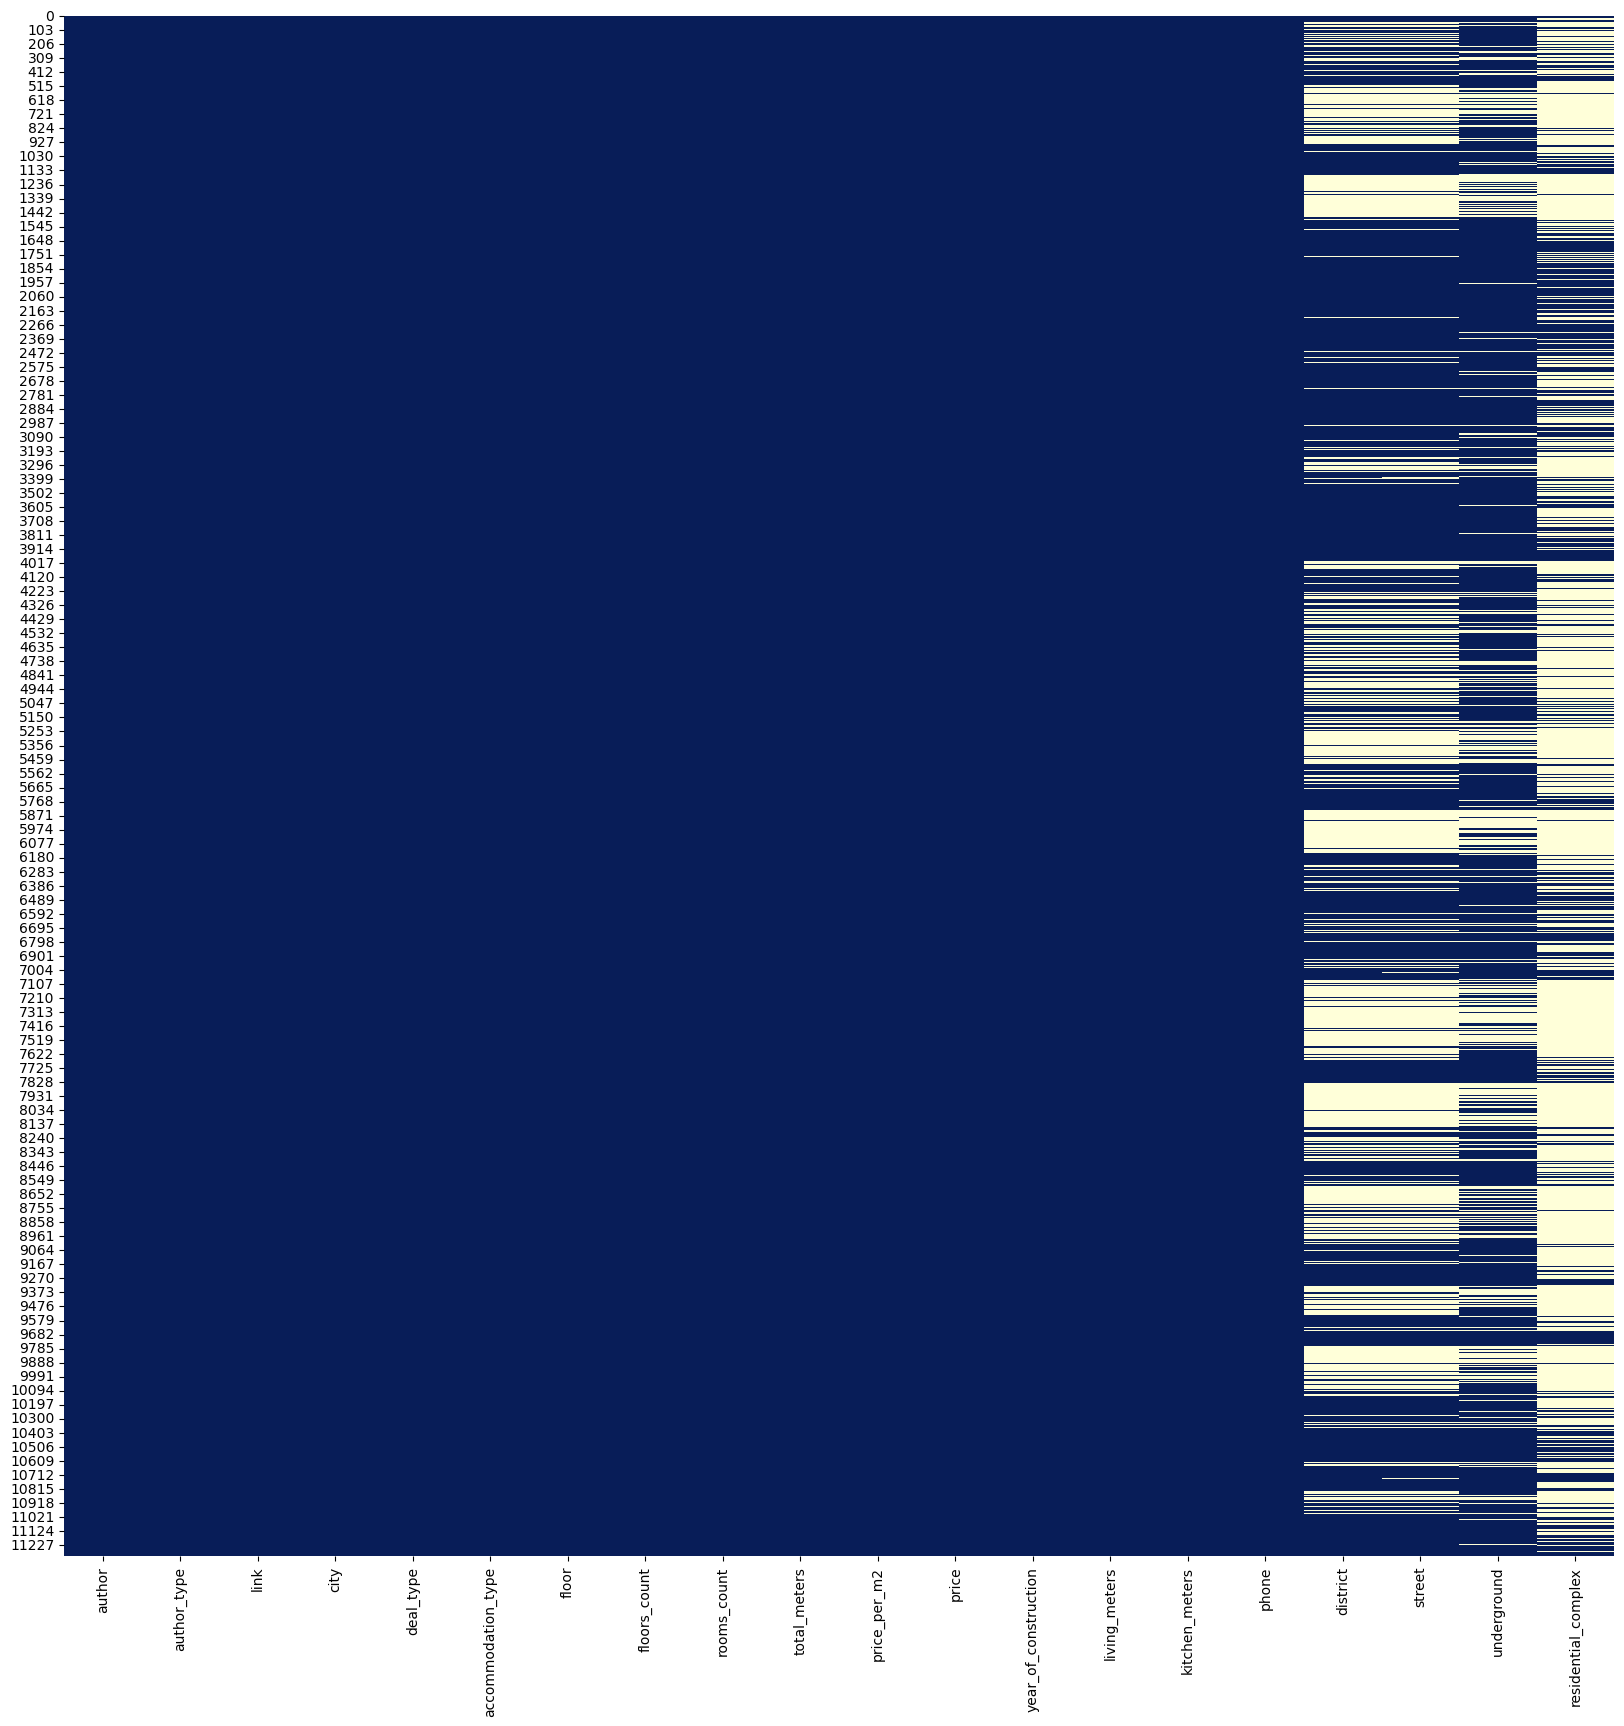

In [381]:
plt.figure(figsize = (20,20))
sns.heatmap(data = df.isnull(),cmap="YlGnBu_r",cbar=False)

In [382]:
df.isna().sum()/df.shape[0]*100

author                   0.035367
author_type              0.035367
link                     0.000000
city                     0.000000
deal_type                0.000000
accommodation_type       0.000000
floor                    0.000000
floors_count             0.000000
rooms_count              0.000000
total_meters             0.000000
price_per_m2             0.000000
price                    0.000000
year_of_construction     0.000000
living_meters            0.000000
kitchen_meters           0.000000
phone                    0.000000
district                36.118479
street                  36.251105
underground             21.786030
residential_complex     67.559682
dtype: float64

In [383]:
df.head(100)

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,Константин Кудрявцев,realtor,https://www.cian.ru/sale/flat/283849683/,Москва_и_др.,sale,flat,1,5,1,12.00,291666,3500000,-1,-1.0,-1.0,79660408670,Текстильщики,Шкулева,Волжская,NaN
1,White and Broughton,real_estate_agent,https://www.cian.ru/sale/flat/280986757/,Москва_и_др.,sale,flat,17,41,1,40.40,618811,25000000,2021,15.2,9.1,79646331510,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк
2,Времена года,real_estate_agent,https://www.cian.ru/sale/flat/286530258/,Москва_и_др.,sale,flat,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,79152007823,Хамовники,Усачева,Спортивная,Садовые кварталы
3,White and Broughton,real_estate_agent,https://www.cian.ru/sale/flat/283638079/,Москва_и_др.,sale,flat,9,41,1,40.50,617283,25000000,2022,17.3,9.3,79646331510,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк
4,ID 44396977,realtor,https://www.cian.ru/sale/flat/287127196/,Москва_и_др.,sale,flat,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,79034356129,Нагатино-Садовники,Нагатинская набережная,Коломенская,NaN
5,Времена года,real_estate_agent,https://www.cian.ru/sale/flat/285378586/,Москва_и_др.,sale,flat,6,13,1,71.10,983122,69900000,2019,37.1,12.8,79152007823,Хамовники,Усачева,Спортивная,Садовые кварталы
6,ИТКОЛ,official_representative,https://www.cian.ru/sale/flat/287529888/,Москва_и_др.,sale,flat,7,9,1,18.00,382000,6876000,-1,-1.0,-1.0,79651098418,Аэропорт,Большой Коптевский проезд,Красный Балтиец,NaN
7,Century 21 Premium Property,real_estate_agent,https://www.cian.ru/sale/flat/287489122/,Москва_и_др.,sale,flat,33,36,1,75.00,626666,47000000,2020,35.0,20.0,79175213146,Хорошево-Мневники,Шелепихинская набережная,Шелепиха,Сердце Столицы
8,СТРОЙИНВЕСТ,real_estate_agent,https://balashikha.cian.ru/sale/flat/281454196/,Москва_и_др.,sale,flat,9,17,1,37.20,147072,5471080,2022,-1.0,-1.0,79647297235,NaN,NaN,Лухмановская,NaN
9,Whitewill,real_estate_agent,https://www.cian.ru/sale/flat/286402225/,Москва_и_др.,sale,flat,6,41,1,41.00,724390,29700000,2022,24.0,6.0,79165694109,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк


In [384]:
df['link']

0        https://www.cian.ru/sale/flat/283849683/
1        https://www.cian.ru/sale/flat/280986757/
2        https://www.cian.ru/sale/flat/286530258/
3        https://www.cian.ru/sale/flat/283638079/
4        https://www.cian.ru/sale/flat/287127196/
                           ...                   
11305    https://www.cian.ru/sale/flat/287703757/
11306    https://www.cian.ru/sale/flat/284652097/
11307    https://www.cian.ru/sale/flat/284644852/
11308    https://www.cian.ru/sale/flat/285604501/
11309    https://www.cian.ru/sale/flat/282401854/
Name: link, Length: 11310, dtype: object

In [385]:
df.shape

(11310, 20)

In [386]:
df = df.drop_duplicates()
df.shape

(8391, 20)

In [387]:
df_cop = df.copy()

# Вычисление ненужных данных

### City

In [388]:
df_cop['city'].unique()

array(['Москва_и_др.'], dtype=object)

In [389]:
df_cop.drop(columns = 'city',inplace = True)

### Ссылка на квартиры нам не понадобиться кроме (!!!!!) того как если бы мы показывали похожие квартиры

In [390]:
df_cop.drop(columns = 'link',inplace = True)

### Deal_type

In [391]:
df_cop['deal_type'].unique()

array(['sale'], dtype=object)

In [392]:
df_cop.drop(columns = 'deal_type',inplace = True)

### Accommodation_type

In [393]:
df_cop['accommodation_type'].unique()

array(['flat'], dtype=object)

In [394]:
df_cop.drop(columns = 'accommodation_type',inplace = True)

### Телефон для нашей модели также не нужен т.к. это индивидуальная информация

In [395]:
df_cop.drop(columns = 'phone',inplace = True)

### Author и Author_type пользователь знать не сможет, т.к. мы просто будем оценивать квартиру

In [396]:
df_cop.drop(columns = ['author','author_type'],inplace = True)

In [397]:
df_cop.sample(20)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex
3944,3,5,5,230.0,1608695,370000000,2009,-1.0,-1.0,Хамовники,2-й Зачатьевский переулок,Парк Культуры,Особняк в Зачатьевском переулке
4496,11,22,-1,27.4,284671,7800000,2022,15.0,5.0,Покровское-Стрешнево,Волоколамское шоссе,Спартак,Движение.Тушино
3751,5,10,5,156.6,996168,156000000,2007,83.0,18.0,Тверской,Цветной бульвар,Цветной бульвар,NaN
53,12,17,1,38.0,214473,8150000,2012,-1.0,-1.0,NaN,NaN,Ховрино,NaN
1604,6,41,3,84.0,475000,39900000,2021,-1.0,-1.0,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк
3646,5,7,5,176.0,625000,110000000,1914,120.0,14.0,Хамовники,1-й Обыденский переулок,Кропоткинская,NaN
6737,6,8,3,104.0,1240384,129000000,2014,-1.0,-1.0,Хамовники,Льва Толстого,Парк Культуры,Литератор
2266,1,11,4,101.0,252475,25500000,1957,76.0,8.0,Гагаринский,Университетский проспект,Университет,NaN
6660,3,5,3,60.8,148026,9000000,1938,43.0,6.1,NaN,NaN,NaN,NaN
4943,3,5,1,18.2,367582,6690000,1971,10.2,3.0,Кузьминки,Окская,Окская,My Space на Окской


Соединяем колонки с адресами и в общем местоположением т.к. в них большое количество пропусков, а информация в них весьма полезна для предсказаний нашей модели

In [398]:
df_cop['address'] = df_cop['district'].fillna('') + ' ' + df_cop['street'].fillna('') + ' ' + df_cop['underground'].fillna('') + \
                    ' ' + df_cop['residential_complex'].fillna('')

In [399]:
df_cop.sample(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex,address
3188,7,7,5,245.6,2774492,681415250,2003,-1.0,25.0,Хамовники,Большой Левшинский переулок,Смоленская,Дворянское гнездо,Хамовники Большой Левшинский переулок Смоленская Дворянское гнездо
8621,10,17,2,43.7,121258,5299000,2022,25.4,8.4,NaN,NaN,NaN,NaN,
9346,3,4,3,57.2,131118,7500000,1966,41.8,5.9,NaN,NaN,Рассказовка,NaN,Рассказовка
125,2,9,1,29.3,375085,10990000,1965,16.0,5.5,Останкинский,2-я Новоостанкинская,Улица Академика Королёва,NaN,Останкинский 2-я Новоостанкинская Улица Академика Королёва
9191,19,24,3,100.9,336967,34000000,2009,45.1,15.9,Можайский,Можайское шоссе,Рабочий посёлок,NaN,Можайский Можайское шоссе Рабочий посёлок
9029,3,17,2,59.7,242881,14500000,1983,33.7,10.0,Люблино,проезд Кирова,Депо,NaN,Люблино проезд Кирова Депо
4345,7,16,1,22.5,280000,6300000,2019,-1.0,-1.0,NaN,NaN,Коммунарка,NaN,Коммунарка
8769,12,19,2,56.1,163992,9200000,2010,34.5,10.0,NaN,NaN,Новокосино,NaN,Новокосино
1941,7,11,4,187.0,962566,180000000,2014,-1.0,-1.0,Хамовники,Ефремова,Спортивная,Садовые кварталы,Хамовники Ефремова Спортивная Садовые кварталы
3880,1,8,5,219.2,1239801,271764435,2010,175.0,-1.0,Гагаринский,Косыгина,Ленинский проспект,Дом Академии Наук РАН,Гагаринский Косыгина Ленинский проспект Дом Академии Наук РАН


In [400]:
df_cop[df_cop['address'] == '   ']

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex,address
30,6,6,1,36.6,133879,4900000,-1,14.5,9.5,NaN,NaN,NaN,NaN,
44,12,17,1,37.1,142773,5296910,2022,13.8,11.9,NaN,NaN,NaN,NaN,
46,2,17,1,37.0,153062,5663320,2022,14.0,13.5,NaN,NaN,NaN,NaN,
51,10,26,1,39.0,243589,9500000,2017,18.0,12.0,NaN,NaN,NaN,NaN,
52,5,9,1,31.0,160967,4990000,2022,-1.0,-1.0,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10972,4,9,4,143.0,272727,39000000,2017,65.2,14.4,NaN,NaN,NaN,NaN,
10996,7,8,4,138.0,326086,45000000,2016,-1.0,-1.0,NaN,NaN,NaN,NaN,
11005,3,6,4,230.0,208695,48000000,-1,150.0,60.0,NaN,NaN,NaN,NaN,
11042,2,6,4,196.0,280612,55000000,-1,120.9,27.0,NaN,NaN,NaN,NaN,


In [401]:
df_cop.drop(df_cop[df_cop['address'] == '   '].index,inplace = True)

И удаляем уже ненужные спаршенные колонки из датасета

In [402]:
df_cop.drop(columns = ['district','street','underground','residential_complex'],inplace = True)

In [403]:
df_cop.sample(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
4144,16,19,1,24.8,584677,14500000,2021,15.0,5.0,Хорошево-Мневники Шелепихинская набережная Хорошёво FreeDOM
11304,3,5,2,42.0,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse
2370,24,28,4,130.0,303846,39500000,2021,59.4,37.7,Филевский парк Береговой проезд Шелепиха мой адрес На Береговом
1095,8,14,1,40.5,451851,18300000,2020,19.0,7.0,Савеловский Старый Петровско-Разумовский проезд Гражданская Аалто
16,9,9,1,31.2,365384,11400000,1961,18.9,5.8,Даниловский Дербеневская набережная Павелецкая
599,18,22,1,33.5,155223,5200000,2021,15.2,9.3,Некрасовка
2536,7,12,4,84.5,201065,16990000,1978,-1.0,6.0,Орехово-Борисово Южное Тамбовская Домодедовская
1295,4,17,1,40.0,132500,5300000,2017,20.0,11.0,Ростокино
2049,10,23,4,185.6,457974,85000000,1999,-1.0,15.0,Крылатское Крылатские Холмы Крылатское
9456,3,25,3,86.7,161987,14044303,2022,55.2,13.7,Некрасовка Липчанского Некрасовка Некрасовка


In [404]:
df_cop['address']

0                                         Текстильщики Шкулева Волжская 
1                 Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2                          Хамовники Усачева Спортивная Садовые кварталы
3                 Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4                 Нагатино-Садовники Нагатинская набережная Коломенская 
                                      ...                               
11150                               Обручевский Островитянова Тропарёво 
11287                  Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
11303    Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
11304      Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse
11309                     Пресненский Мантулинская Выставочная City Park
Name: address, Length: 6930, dtype: object

Смотрим на nan значения

<Axes: >

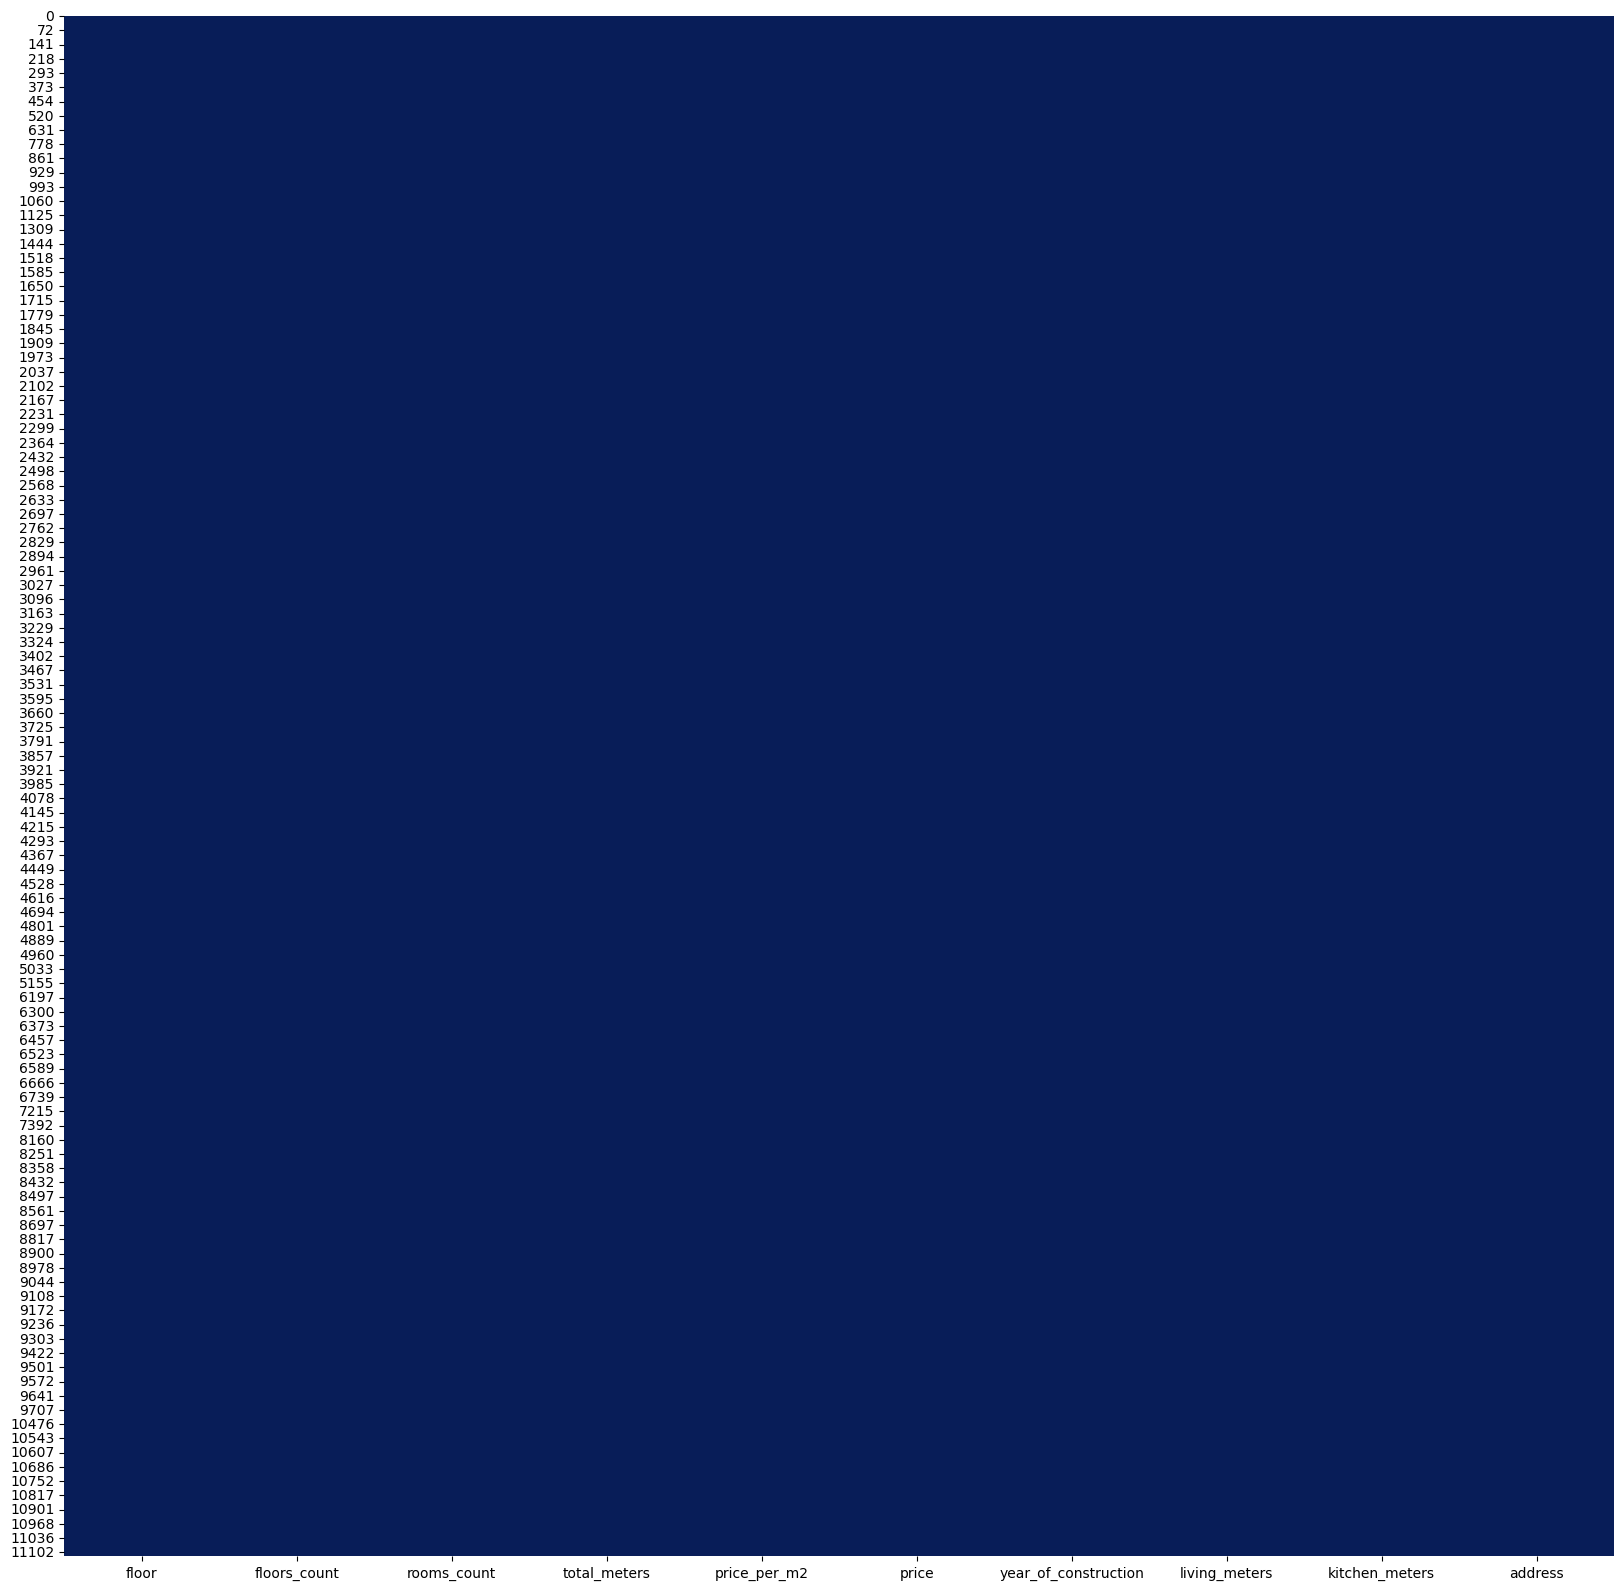

In [405]:
plt.figure(figsize = (20,20))
sns.heatmap(data = df_cop.isnull(),cmap="YlGnBu_r",cbar=False)

In [406]:
df_cop.isna().sum()/df.shape[0]*100

floor                   0.0
floors_count            0.0
rooms_count             0.0
total_meters            0.0
price_per_m2            0.0
price                   0.0
year_of_construction    0.0
living_meters           0.0
kitchen_meters          0.0
address                 0.0
dtype: float64

In [407]:
df_cop.dropna(inplace = True)
df_cop.reset_index(drop = True,inplace = True)
df_cop.head(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,1,5,1,12.00,291666,3500000,-1,-1.0,-1.0,Текстильщики Шкулева Волжская
1,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
3,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
5,6,13,1,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
6,7,9,1,18.00,382000,6876000,-1,-1.0,-1.0,Аэропорт Большой Коптевский проезд Красный Балтиец
7,33,36,1,75.00,626666,47000000,2020,35.0,20.0,Хорошево-Мневники Шелепихинская набережная Шелепиха Сердце Столицы
8,9,17,1,37.20,147072,5471080,2022,-1.0,-1.0,Лухмановская
9,6,41,1,41.00,724390,29700000,2022,24.0,6.0,Хорошевский Ленинградский проспект Аэропорт Прайм Парк


In [408]:
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,1,5,1,12.00,291666,3500000,-1,-1.0,-1.0,Текстильщики Шкулева Волжская
1,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
3,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
...,...,...,...,...,...,...,...,...,...,...
6925,11,22,4,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6926,11,17,4,172.63,434455,74999999,2008,-1.0,-1.0,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6927,37,78,2,73.00,602739,44000000,2020,-1.0,-1.0,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6928,3,5,2,42.00,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [409]:
print('floor')
print(np.sort(df_cop['floor'].unique()))
print('floors_count')
print(np.sort(df_cop['floors_count'].unique()))
print('rooms_count')
print(np.sort(df_cop['rooms_count'].unique()))
print('total_meters')
print(np.sort(df_cop['total_meters'].unique()))
print('price_per_m2')
print(np.sort(df_cop['price_per_m2'].unique()))
print('year_of_construction')
print(np.sort(df_cop['year_of_construction'].unique()))
print('living_meters')
print(np.sort(df_cop['living_meters'].unique()))
print('kitchen_meters')
print(np.sort(df_cop['kitchen_meters'].unique()))

floor
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 61 62 63 66 67 75 78 79 92]
floors_count
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 63 64 65 67 69 73 75 76 77 78 79
 82 85 86 87 95]
rooms_count
[-1  1  2  3  4  5]
total_meters
[-1.0000e+00  1.0100e-01  1.2000e-01  7.5000e+00  8.7000e+00  1.0000e+01
  1.0300e+01  1.0400e+01  1.0500e+01  1.0600e+01  1.1000e+01  1.1100e+01
  1.1400e+01  1.1500e+01  1.1600e+01  1.1700e+01  1.1800e+01  1.1900e+01
  1.2000e+01  1.2100e+01  1.2300e+01  1.2400e+01  1.2500e+01  1.2600e+01
  1.2700e+01  1.2800e+01  1.3000e+01  1.3100e+01  1.3300e+01  1.3400e+01
  1.3500e+01  1.3600e+01  1.3700e+01  1.3800e+01  1.3900e+01  1.4000e+01
  1.4100e+01  1.4200e+01  1.4300e+01  1.4400e+01  1.45

# Выбросы

In [410]:
def quantiles(arr):
    work_val = arr.copy()
    Q1 = work_val.quantile(0.25)#np.percentile(work_val, 25, method= 'midpoint')
    Q3 = work_val.quantile(0.75)#np.percentile(work_val, 75, method= 'midpoint')
    IQR = Q3-Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    return upper,lower

def anti_emmi(df):
    if df.select_dtypes(include = [np.number]).all().any():
        for col in df.select_dtypes(include = [np.number]).columns:
            
            up,low = quantiles(df[col])
            df = df[~(df[col] < low) | (df[col] > up)]

    return df.reset_index(drop=True)

In [411]:
df_cop = anti_emmi(df_cop)
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
1,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
2,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
3,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
4,6,13,1,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
...,...,...,...,...,...,...,...,...,...,...
6230,11,22,4,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6231,11,17,4,172.63,434455,74999999,2008,-1.0,-1.0,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6232,37,78,2,73.00,602739,44000000,2020,-1.0,-1.0,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6233,3,5,2,42.00,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [412]:
df_cop.columns

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'price', 'year_of_construction', 'living_meters', 'kitchen_meters',
       'address'],
      dtype='object')

In [413]:
df_cop.loc[df_cop['rooms_count'] == -1,'rooms_count'].index

Int64Index([3288, 3290, 3291, 3292, 3294, 3297, 3302, 3303, 3304, 3307,
            ...
            4356, 4366, 4373, 4374, 4383, 4388, 4394, 4395, 4407, 4410],
           dtype='int64', length=163)

In [414]:
for col in df_cop.drop(columns = 'address').columns:
    print(col)
    print(df_cop[df_cop[col]<0][col].unique())

floor
[-1]
floors_count
[-1]
rooms_count
[-1]
total_meters
[]
price_per_m2
[]
price
[]
year_of_construction
[]
living_meters
[-1.]
kitchen_meters
[-1.]


Если значение = -1 (тоесть отсутствует) оно заменяется на среднее по колонке

In [415]:
# for col in df_cop.drop(columns = ['address','year_of_construction']).columns:
#     df_cop.loc[df_cop[col] == -1,col] = (df_cop[df_cop != -1][col].sum()//df_cop[df_cop != -1][col].count())

In [416]:
# df_cop[(df_cop['year_of_construction'] == 2020) & (df_cop['living_meters'] != -1)]['living_meters'].mean()

In [417]:
# def meen(year):
#     return round(df_cop[(df_cop['year_of_construction'] == year) & (df_cop[col] != -1)][col].mean(),1)

In [418]:
# for col in df_cop.columns:
#     df_cop.loc[df_cop[col] == -1,col] = df_cop.loc[df_cop[col] == -1,'year_of_construction'].apply(meen)

In [419]:
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
1,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
2,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
3,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
4,6,13,1,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
...,...,...,...,...,...,...,...,...,...,...
6230,11,22,4,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6231,11,17,4,172.63,434455,74999999,2008,-1.0,-1.0,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6232,37,78,2,73.00,602739,44000000,2020,-1.0,-1.0,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6233,3,5,2,42.00,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [420]:
df_cop.describe()

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters
count,6235.000000,6235.000000,6235.000000,6235.000000,6.235000e+03,6.235000e+03,6235.000000,6235.000000,6235.000000
mean,9.177386,17.412510,2.901684,107.561481,5.280821e+05,7.036006e+07,2000.273617,40.840529,10.797209
std,8.591221,12.348011,1.579196,80.224464,2.283440e+06,1.044957e+08,28.308900,48.546983,10.069325
min,-1.000000,-1.000000,-1.000000,0.101000,5.971800e+04,2.000000e+06,1902.000000,-1.000000,-1.000000
25%,3.000000,9.000000,1.000000,44.000000,2.550250e+05,1.170000e+07,1996.000000,-1.000000,4.000000
50%,6.000000,15.000000,3.000000,86.000000,3.706290e+05,3.100000e+07,2012.000000,24.500000,10.000000
75%,12.000000,23.000000,4.000000,150.000000,6.008325e+05,8.200000e+07,2020.000000,64.000000,15.600000
max,92.000000,95.000000,5.000000,885.000000,1.782178e+08,1.650000e+09,2024.000000,680.000000,99.000000


In [421]:
df_cop = df_cop.drop(df_cop[df_cop['total_meters']<13].index)
df_cop.describe()

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters
count,6200.000000,6200.000000,6200.000000,6200.000000,6.200000e+03,6.200000e+03,6200.000000,6200.000000,6200.000000
mean,9.207742,17.441129,2.916935,108.106924,5.003751e+05,7.073291e+07,2000.342903,41.046613,10.852968
std,8.589380,12.340968,1.568371,80.120339,3.861796e+05,1.046719e+08,28.285221,48.600436,10.067434
min,-1.000000,-1.000000,-1.000000,13.000000,5.971800e+04,2.000000e+06,1902.000000,-1.000000,-1.000000
25%,3.000000,9.000000,2.000000,44.300000,2.545810e+05,1.190000e+07,1997.000000,-1.000000,4.175000
50%,7.000000,15.000000,3.000000,87.050000,3.715790e+05,3.170000e+07,2012.000000,25.000000,10.000000
75%,12.000000,23.000000,4.000000,150.100000,6.027158e+05,8.291250e+07,2020.000000,64.300000,15.700000
max,92.000000,95.000000,5.000000,885.000000,4.583333e+06,1.650000e+09,2024.000000,680.000000,99.000000


In [422]:
df_cop.shape

(6200, 10)

In [423]:
for col in df_cop.drop(columns = 'address').columns:
    print(col)
    print(df_cop[df_cop[col]<0][col].unique())

floor
[-1]
floors_count
[-1]
rooms_count
[-1]
total_meters
[]
price_per_m2
[]
price
[]
year_of_construction
[]
living_meters
[-1.]
kitchen_meters
[-1.]


In [424]:
df_cop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 6234
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   floor                 6200 non-null   int64  
 1   floors_count          6200 non-null   int64  
 2   rooms_count           6200 non-null   int64  
 3   total_meters          6200 non-null   float64
 4   price_per_m2          6200 non-null   int64  
 5   price                 6200 non-null   int64  
 6   year_of_construction  6200 non-null   int64  
 7   living_meters         6200 non-null   float64
 8   kitchen_meters        6200 non-null   float64
 9   address               6200 non-null   object 
dtypes: float64(3), int64(6), object(1)
memory usage: 532.8+ KB


<Axes: >

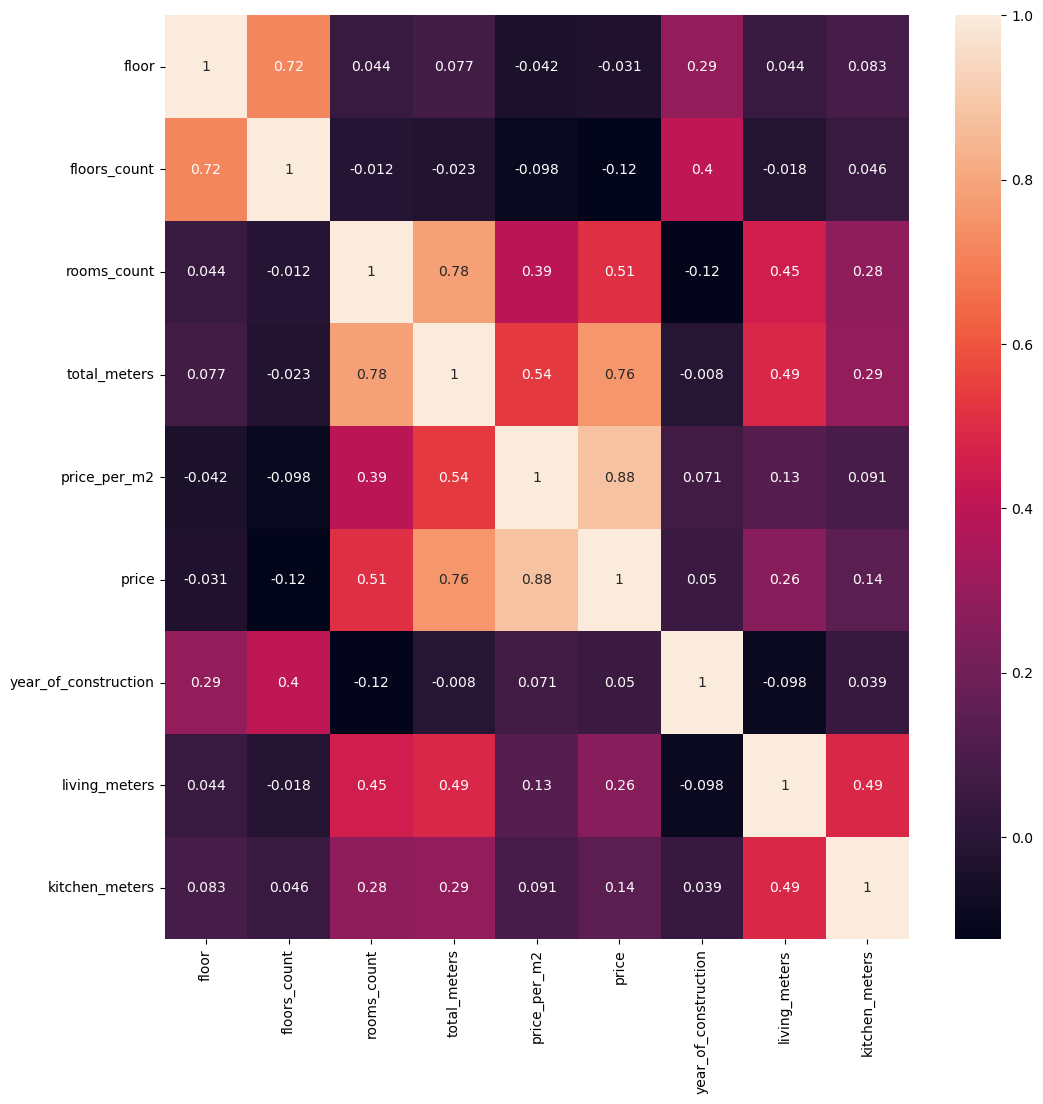

In [425]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

<Axes: >

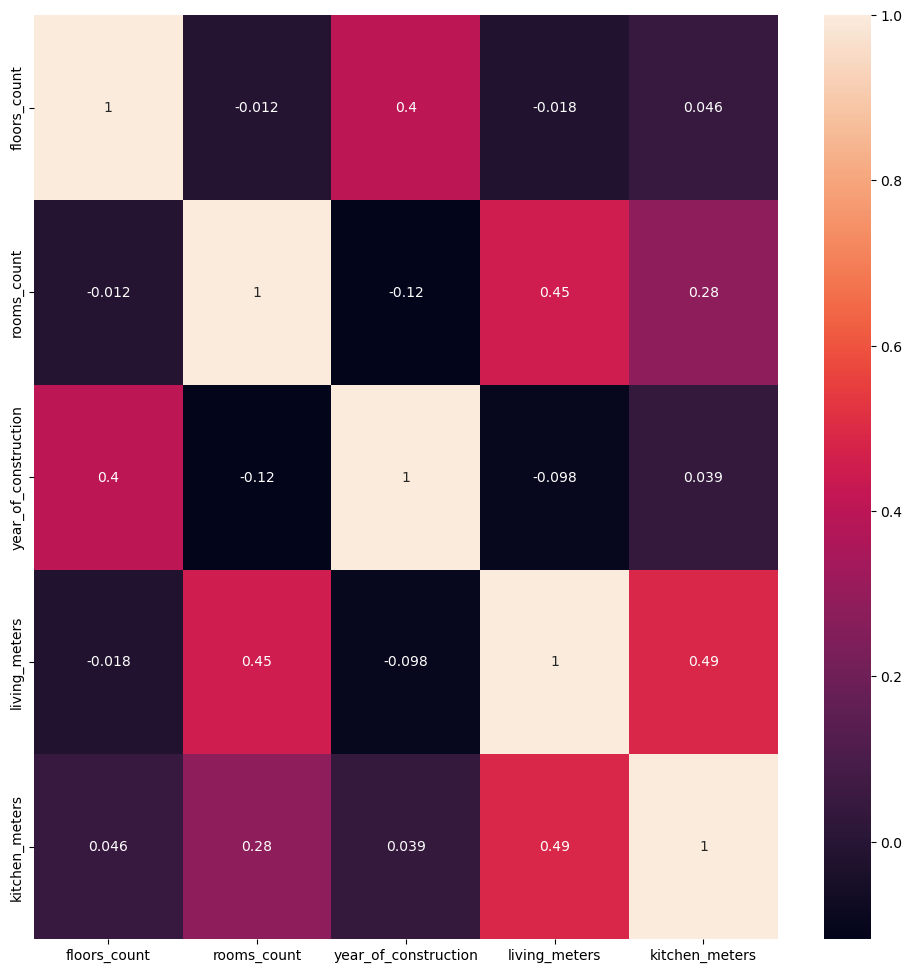

In [442]:
plt.figure(figsize = (12,12))
sns.heatmap(X.drop(columns = 'floor').corr(),annot = True)

In [427]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    #if len(tokens) > 2:
    return tokens
    #return None
    
df_cop['address'] = df_cop['address'].apply(lemmatize)

In [428]:
def concat(text):
    text= ' '.join(text)
    return text

df_cop['address'] = df_cop['address'].apply(concat)

# Модели

In [439]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
y = df_cop['price_per_m2']

In [452]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [453]:
df_cop.columns

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'price', 'year_of_construction', 'living_meters', 'kitchen_meters',
       'address'],
      dtype='object')

In [434]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(df_cop.drop(columns = ['address','price','total_meters','price_per_m2']))

In [456]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=8,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])


0:	learn: 230450.7941263	total: 28.5ms	remaining: 28.4s
1:	learn: 220169.1960721	total: 52.3ms	remaining: 26.1s
2:	learn: 210137.1632068	total: 74.6ms	remaining: 24.8s
3:	learn: 202618.6828893	total: 97.6ms	remaining: 24.3s
4:	learn: 195687.0790661	total: 120ms	remaining: 23.8s
5:	learn: 190322.0014883	total: 147ms	remaining: 24.4s
6:	learn: 185815.1384603	total: 174ms	remaining: 24.6s
7:	learn: 179547.8141934	total: 197ms	remaining: 24.4s
8:	learn: 174022.2461775	total: 219ms	remaining: 24.1s
9:	learn: 171451.1530475	total: 252ms	remaining: 25s
10:	learn: 167702.2095572	total: 282ms	remaining: 25.3s
11:	learn: 164946.0595333	total: 305ms	remaining: 25.1s
12:	learn: 161645.9947631	total: 327ms	remaining: 24.8s
13:	learn: 159464.1910241	total: 351ms	remaining: 24.7s
14:	learn: 157588.6876794	total: 372ms	remaining: 24.4s
15:	learn: 156232.2015086	total: 396ms	remaining: 24.3s
16:	learn: 153971.0623290	total: 418ms	remaining: 24.2s
17:	learn: 152239.0436534	total: 442ms	remaining: 24.1s


150:	learn: 110460.7284088	total: 4.02s	remaining: 22.6s
151:	learn: 110325.9547638	total: 4.05s	remaining: 22.6s
152:	learn: 110097.5277684	total: 4.08s	remaining: 22.6s
153:	learn: 109997.8421478	total: 4.1s	remaining: 22.5s
154:	learn: 109763.2298180	total: 4.13s	remaining: 22.5s
155:	learn: 109300.0543809	total: 4.15s	remaining: 22.5s
156:	learn: 109184.1383360	total: 4.17s	remaining: 22.4s
157:	learn: 109002.5339658	total: 4.2s	remaining: 22.4s
158:	learn: 108894.5276551	total: 4.22s	remaining: 22.3s
159:	learn: 108832.5342041	total: 4.25s	remaining: 22.3s
160:	learn: 108712.9312365	total: 4.27s	remaining: 22.3s
161:	learn: 108514.2216271	total: 4.3s	remaining: 22.2s
162:	learn: 108206.1429124	total: 4.32s	remaining: 22.2s
163:	learn: 108059.9472844	total: 4.34s	remaining: 22.1s
164:	learn: 107784.2146930	total: 4.37s	remaining: 22.1s
165:	learn: 107616.5401734	total: 4.39s	remaining: 22.1s
166:	learn: 107425.2406573	total: 4.42s	remaining: 22s
167:	learn: 107262.4379284	total: 4.

297:	learn: 94822.4477007	total: 8.34s	remaining: 19.6s
298:	learn: 94740.0448377	total: 8.38s	remaining: 19.6s
299:	learn: 94620.6568588	total: 8.43s	remaining: 19.7s
300:	learn: 94601.3928975	total: 8.47s	remaining: 19.7s
301:	learn: 94504.2078072	total: 8.52s	remaining: 19.7s
302:	learn: 94437.6013904	total: 8.56s	remaining: 19.7s
303:	learn: 94322.9661596	total: 8.6s	remaining: 19.7s
304:	learn: 94277.6611726	total: 8.68s	remaining: 19.8s
305:	learn: 94224.3006498	total: 8.74s	remaining: 19.8s
306:	learn: 94103.1306248	total: 8.79s	remaining: 19.8s
307:	learn: 94013.8707507	total: 8.87s	remaining: 19.9s
308:	learn: 93954.9765211	total: 8.91s	remaining: 19.9s
309:	learn: 93921.3631958	total: 8.96s	remaining: 19.9s
310:	learn: 93794.4814123	total: 8.99s	remaining: 19.9s
311:	learn: 93707.6204112	total: 9.03s	remaining: 19.9s
312:	learn: 93647.1876327	total: 9.06s	remaining: 19.9s
313:	learn: 93622.5432083	total: 9.09s	remaining: 19.9s
314:	learn: 93574.1282501	total: 9.13s	remaining:

449:	learn: 85910.9477537	total: 13.3s	remaining: 16.3s
450:	learn: 85807.3635786	total: 13.4s	remaining: 16.3s
451:	learn: 85795.6821450	total: 13.4s	remaining: 16.2s
452:	learn: 85761.4097570	total: 13.4s	remaining: 16.2s
453:	learn: 85702.5100775	total: 13.4s	remaining: 16.2s
454:	learn: 85700.6728195	total: 13.5s	remaining: 16.1s
455:	learn: 85688.5633203	total: 13.5s	remaining: 16.1s
456:	learn: 85649.4104776	total: 13.5s	remaining: 16.1s
457:	learn: 85640.9820114	total: 13.5s	remaining: 16s
458:	learn: 85630.4559311	total: 13.6s	remaining: 16s
459:	learn: 85568.7714076	total: 13.6s	remaining: 16s
460:	learn: 85545.5871293	total: 13.6s	remaining: 15.9s
461:	learn: 85485.5638851	total: 13.7s	remaining: 15.9s
462:	learn: 85446.0261445	total: 13.7s	remaining: 15.9s
463:	learn: 85434.3612304	total: 13.7s	remaining: 15.8s
464:	learn: 85411.7310255	total: 13.7s	remaining: 15.8s
465:	learn: 85371.2347318	total: 13.8s	remaining: 15.8s
466:	learn: 85272.6125532	total: 13.8s	remaining: 15.7

600:	learn: 80854.8981856	total: 17.1s	remaining: 11.4s
601:	learn: 80791.9453951	total: 17.2s	remaining: 11.3s
602:	learn: 80726.8094440	total: 17.2s	remaining: 11.3s
603:	learn: 80712.7540385	total: 17.2s	remaining: 11.3s
604:	learn: 80685.4114390	total: 17.2s	remaining: 11.2s
605:	learn: 80657.0263808	total: 17.2s	remaining: 11.2s
606:	learn: 80628.1691505	total: 17.3s	remaining: 11.2s
607:	learn: 80620.8732496	total: 17.3s	remaining: 11.1s
608:	learn: 80611.0024511	total: 17.3s	remaining: 11.1s
609:	learn: 80597.1304786	total: 17.3s	remaining: 11.1s
610:	learn: 80579.4467282	total: 17.4s	remaining: 11.1s
611:	learn: 80560.1084058	total: 17.4s	remaining: 11s
612:	learn: 80463.6672279	total: 17.4s	remaining: 11s
613:	learn: 80453.4921179	total: 17.4s	remaining: 11s
614:	learn: 80430.2080757	total: 17.5s	remaining: 10.9s
615:	learn: 80349.1131848	total: 17.5s	remaining: 10.9s
616:	learn: 80303.8171539	total: 17.5s	remaining: 10.9s
617:	learn: 80297.4148210	total: 17.5s	remaining: 10.8

756:	learn: 76185.5080460	total: 20.7s	remaining: 6.64s
757:	learn: 76150.5791255	total: 20.7s	remaining: 6.61s
758:	learn: 76105.9830842	total: 20.7s	remaining: 6.58s
759:	learn: 76047.2343472	total: 20.8s	remaining: 6.56s
760:	learn: 76034.0711272	total: 20.8s	remaining: 6.53s
761:	learn: 75876.9158746	total: 20.8s	remaining: 6.5s
762:	learn: 75873.5559555	total: 20.8s	remaining: 6.47s
763:	learn: 75839.6897016	total: 20.8s	remaining: 6.44s
764:	learn: 75835.3644143	total: 20.9s	remaining: 6.41s
765:	learn: 75834.0050088	total: 20.9s	remaining: 6.38s
766:	learn: 75816.9155313	total: 20.9s	remaining: 6.35s
767:	learn: 75807.6944154	total: 20.9s	remaining: 6.33s
768:	learn: 75789.2614022	total: 21s	remaining: 6.3s
769:	learn: 75782.1599897	total: 21s	remaining: 6.27s
770:	learn: 75777.0452546	total: 21s	remaining: 6.24s
771:	learn: 75736.8731773	total: 21s	remaining: 6.21s
772:	learn: 75727.1739809	total: 21s	remaining: 6.18s
773:	learn: 75691.7710181	total: 21.1s	remaining: 6.15s
774:

913:	learn: 72527.4278292	total: 24.2s	remaining: 2.28s
914:	learn: 72525.1272282	total: 24.2s	remaining: 2.25s
915:	learn: 72519.1676635	total: 24.3s	remaining: 2.23s
916:	learn: 72451.7320113	total: 24.3s	remaining: 2.2s
917:	learn: 72451.0570440	total: 24.3s	remaining: 2.17s
918:	learn: 72428.8084616	total: 24.3s	remaining: 2.14s
919:	learn: 72383.9492394	total: 24.4s	remaining: 2.12s
920:	learn: 72383.5749790	total: 24.4s	remaining: 2.09s
921:	learn: 72374.8837416	total: 24.4s	remaining: 2.06s
922:	learn: 72370.5146922	total: 24.4s	remaining: 2.04s
923:	learn: 72369.4519839	total: 24.4s	remaining: 2.01s
924:	learn: 72369.3074050	total: 24.5s	remaining: 1.98s
925:	learn: 72354.6065190	total: 24.5s	remaining: 1.96s
926:	learn: 72343.3843560	total: 24.5s	remaining: 1.93s
927:	learn: 72342.6101868	total: 24.5s	remaining: 1.9s
928:	learn: 72339.1801583	total: 24.6s	remaining: 1.88s
929:	learn: 72333.4477926	total: 24.6s	remaining: 1.85s
930:	learn: 72330.9644796	total: 24.6s	remaining: 

In [457]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

133255.4201656512

In [445]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 81 candidates, totalling 162 fits



KeyboardInterrupt



In [329]:
gs.best_params_, gs.best_score_

({'depth': 8, 'learning_rate': 0.1}, 0.5614196154773416)

In [169]:
# import joblib
# joblib.dump(fit_model_price_m2, "price_m2_5.joblib")

['price_m2_5.joblib']

In [ ]:
# X = np.append(X_plus,df_cop.drop(columns = ['address','price','total_meters']), axis=1)
# y = df_cop['price']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42)

In [ ]:
# model = CatBoostRegressor(learning_rate=0.2, depth=7, loss_function='MAE',verbose=False)
# fit_model_price = model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_test, fit_model_price.predict(X_test))

In [247]:
from catboost import Pool, cv
params = {"iterations": 1001,
          "depth": 3,
          "loss_function": "MAE",
          "verbose": False,
          "learning_rate": 0.4,
          "eval_metric": "MAE"}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 171305.43
bestIteration = 371

Training on fold [1/2]

bestTest = 175717.9144
bestIteration = 532



In [ ]:
# X = np.append(X_plus,df_cop.drop(columns = ['address','price','total_meters']), axis=1)
# y = df_cop['total_meters']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42)

In [ ]:
# from catboost import Pool, cv
# params = {"iterations": 1001,
#           "depth": 6,
#           "loss_function": "MAE",
#           "verbose": False,
#           "learning_rate": 0.5,
#           "eval_metric": "MAE"}
# cv_dataset = Pool(data=X_train,
#                   label=y_train)
# scores = cv(cv_dataset,
#             params,
#             fold_count=2, 
#             plot="True")

In [ ]:
df_cop.describe()

In [ ]:
df.describe()

In [ ]:
# fit_model_price_m2.predict(X_test)

In [ ]:
# y_test

In [ ]:
# total_meters минимальное - 0.1
# year_of_construction - 2024
# one hot кодир